# Importing Dependencies

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
import itertools
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
os.chdir("/Users/c_shashank/Desktop/PHDML/")

# Importing Data

In [3]:
data = pd.read_csv("ExistingCustomersTransactionsData.csv")

# Exploratory Data Analysis

In [4]:
data.shape

(29982, 7)

In [5]:
data.head()

BillNumber    BillDate CustomerID ProductID  ProductCategory    Sales  \
0     B32607  2014-01-03     C14797    PR7138  Office Supplies   16.448   
1     B37616  2014-01-03     C13917    PR7138  Office Supplies   16.448   
2     B42625  2014-01-03     C14353    PR7138  Office Supplies   16.448   
3     B32712  2014-01-04     C13351    PR7099  Office Supplies   11.784   
4     B32712  2014-01-04     C13351    PR7490  Office Supplies  272.736   

   Quantity  
0         2  
1         2  
2         2  
3         3  
4         3

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29982 entries, 0 to 29981
Data columns (total 7 columns):
BillNumber         29982 non-null object
BillDate           29982 non-null object
CustomerID         29982 non-null object
ProductID          29982 non-null object
ProductCategory    29982 non-null object
Sales              29982 non-null float64
Quantity           29982 non-null int64
dtypes: float64(1), int64(1), object(5)
memory usage: 1.6+ MB


In [7]:
data.describe()

Sales      Quantity
count  29982.000000  29982.000000
mean     229.858001      3.789574
std      623.224312      2.225035
min        0.444000      1.000000
25%       17.280000      2.000000
50%       54.490000      3.000000
75%      209.940000      5.000000
max    22638.480000     14.000000

In [8]:
data.isnull().sum()

BillNumber         0
BillDate           0
CustomerID         0
ProductID          0
ProductCategory    0
Sales              0
Quantity           0
dtype: int64

In [9]:
col_names = data.columns

In [10]:
for i in col_names:
    distinct_values = len(data[i].unique())
    print(i)
    print(distinct_values)

BillNumber
15027
BillDate
1237
CustomerID
2379
ProductID
1862
ProductCategory
3
Sales
5825
Quantity
14


In [11]:
data.Quantity.value_counts()

3     7227
2     7206
5     3690
4     3573
1     2697
7     1818
6     1716
9      774
8      771
10     171
11     102
14      87
13      81
12      69
Name: Quantity, dtype: int64

In [12]:
data.ProductCategory.value_counts()

Office Supplies    18078
Furniture           6363
Technology          5541
Name: ProductCategory, dtype: int64

# Subsetting out the Rows where Product Category is Furniture

In [13]:
data_furniture = data.loc[data['ProductCategory'] == 'Furniture']

In [14]:
data_furniture.shape

(6363, 7)

In [15]:
data_furniture.head()

BillNumber    BillDate CustomerID ProductID ProductCategory     Sales  \
17     B33327  2014-01-06     C13559    PR6230       Furniture  2573.820   
26     B38336  2014-01-06     C14305    PR6230       Furniture  2573.820   
35     B43345  2014-01-06     C14916    PR6230       Furniture  2573.820   
42     B32629  2014-01-07     C14300    PR6423       Furniture    76.728   
44     B37638  2014-01-07     C13236    PR6423       Furniture    76.728   

    Quantity  
17         9  
26         9  
35         9  
42         3  
44         3

In [16]:
data_furniture.Quantity.value_counts()

3     1602
2     1509
5      759
4      741
1      579
6      363
7      345
9      174
8      174
10      36
11      24
14      24
12      18
13      15
Name: Quantity, dtype: int64

In [17]:
data_furniture["BillDate"].min(), data_furniture["BillDate"].max()

('2014-01-06', '2017-12-30')

## Dropping all other columns except Bill Date and Quantity

In [18]:
drop_cols = ["BillNumber", "CustomerID", "ProductID", "ProductCategory","Sales"]

In [19]:
data_furniture = data_furniture.drop(drop_cols, axis = 1)

In [20]:
data_furniture.shape

(6363, 2)

## Aggreagating data by taking sum of quantity

In [21]:
data_furniture = data_furniture.groupby("BillDate")["Quantity"].sum().reset_index()

In [22]:
data_furniture.head(20)

BillDate  Quantity
0   2014-01-06        27
1   2014-01-07         9
2   2014-01-10         3
3   2014-01-11         6
4   2014-01-13        27
5   2014-01-14        12
6   2014-01-16        18
7   2014-01-19        15
8   2014-01-20        45
9   2014-01-21         9
10  2014-01-26        24
11  2014-01-27         9
12  2014-01-31         6
13  2014-02-08         6
14  2014-02-11        30
15  2014-02-12         6
16  2014-02-18        15
17  2014-02-20        12
18  2014-03-01        69
19  2014-03-03        24

In [23]:
data_furniture.shape

(889, 2)

## Using Bill Date as Index

In [24]:
data_furniture = data_furniture.set_index('BillDate')
data_furniture.index

Index(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11', '2014-01-13',
       '2014-01-14', '2014-01-16', '2014-01-19', '2014-01-20', '2014-01-21',
       ...
       '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22', '2017-12-23',
       '2017-12-24', '2017-12-25', '2017-12-28', '2017-12-29', '2017-12-30'],
      dtype='object', name='BillDate', length=889)

In [25]:
data_furniture.index = pd.to_datetime(data_furniture.index,yearfirst=True)

In [26]:
monthly_data_furniture = data_furniture['Quantity'].resample('MS').sum()

In [27]:
monthly_data_furniture.head()

BillDate
2014-01-01    210
2014-02-01     69
2014-03-01    393
2014-04-01    243
2014-05-01    291
Freq: MS, Name: Quantity, dtype: int64

In [28]:
import plotly
import cufflinks as cf

In [29]:
from plotly.offline import download_plotlyjs, init_notebook_mode,plot,iplot, plot_mpl
init_notebook_mode(connected=True)
cf.go_offline()

# Distribution of our Dataset

In [30]:
monthly_data_furniture.iplot(title="Furniture sales from 2014 to 2017")

# Getting Trend, Seasonality and Randomness from the original distribution

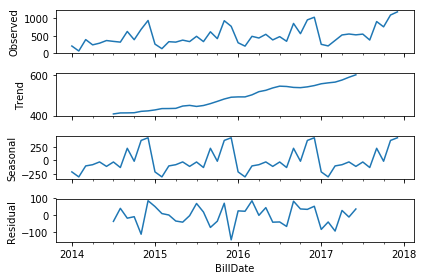

In [31]:
from plotly.plotly import plot_mpl
dec_plot = seasonal_decompose(monthly_data_furniture, model= "Additive")
fig = dec_plot.plot()

In [32]:
plot_mpl(fig)
#display(temp-plot.html)

Aw, snap! We didn't get a username with your request.

Don't have an account? https://plot.ly/api_signup

Questions? accounts@plot.ly


''

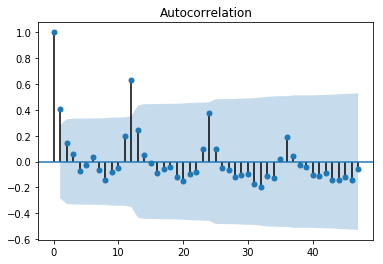

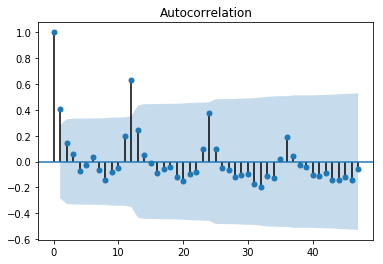

In [33]:
plot_acf(monthly_data_furniture)

/Users/c_shashank/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning:

invalid value encountered in sqrt



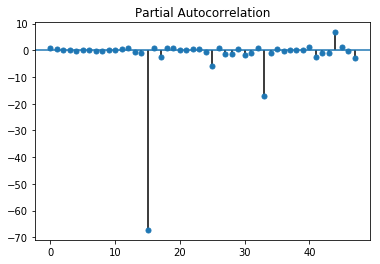

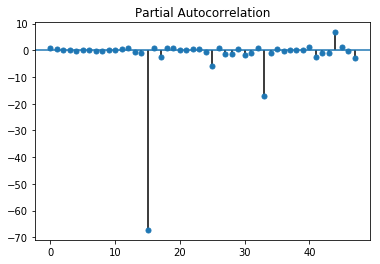

In [34]:
plot_pacf(monthly_data_furniture)

## Creating Function for checking Stationarity of our Dataset

In [35]:
from statsmodels.tsa.stattools import adfuller
window = 12
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    orig = plt.plot(monthly_data_furniture, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(monthly_data_furniture, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

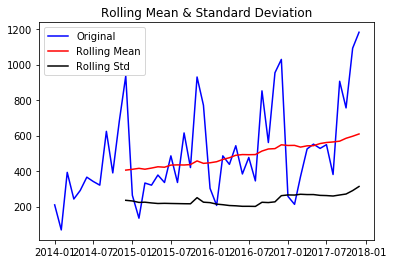

Results of Dickey-Fuller Test:
Test Statistic                 -3.677030
p-value                         0.004448
#Lags Used                      0.000000
Number of Observations Used    47.000000
Critical Value (1%)            -3.577848
Critical Value (5%)            -2.925338
Critical Value (10%)           -2.600774
dtype: float64


In [36]:
test_stationarity(monthly_data_furniture)

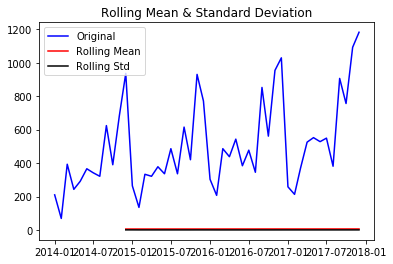

Results of Dickey-Fuller Test:
Test Statistic                 -3.677030
p-value                         0.004448
#Lags Used                      0.000000
Number of Observations Used    47.000000
Critical Value (1%)            -3.577848
Critical Value (5%)            -2.925338
Critical Value (10%)           -2.600774
dtype: float64


In [37]:
monthly_data_furniture_log = np.log(monthly_data_furniture)
test_stationarity(monthly_data_furniture_log)

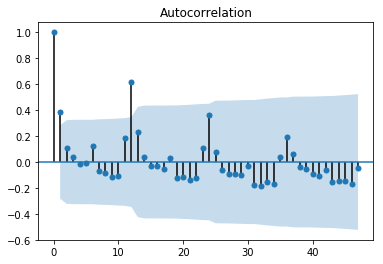

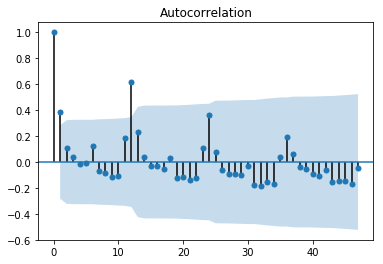

In [38]:
plot_acf(monthly_data_furniture_log)

/Users/c_shashank/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning:

invalid value encountered in sqrt



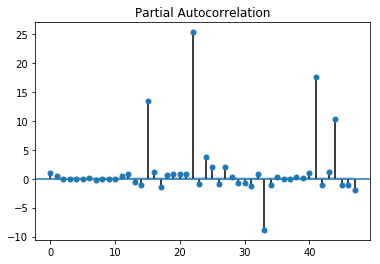

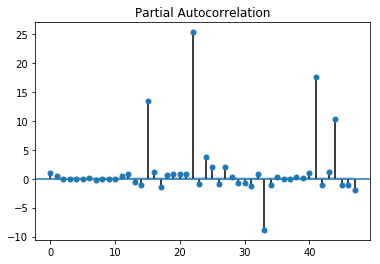

In [39]:
plot_pacf(monthly_data_furniture_log)

In [39]:
monthly_data_furniture_log.iplot(title="Log Furniture Sales from 2014-2018")

# Model Building

## Two important factors - a) No trend in our residuals b) Residual plot should assume Normal Distribution(0 mean)

## Auto Arima Model

In [40]:
from pmdarima.arima import auto_arima

In [41]:
stepwise_model_log = auto_arima(monthly_data_furniture, start_p=0, start_q=0,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model_log.aic())

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=450.863, BIC=453.973, Fit time=0.579 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=434.725, BIC=440.946, Fit time=0.360 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=439.339, BIC=444.005, Fit time=0.070 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=436.713, BIC=444.490, Fit time=0.813 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=444.461, BIC=449.128, Fit time=0.280 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=434.754, BIC=442.531, Fit

In [42]:
train = monthly_data_furniture_log.loc['2014-01-01':'2016-12-31']
test = monthly_data_furniture_log.loc['2017-01-01':]
train.shape, test.shape

((36,), (12,))

In [43]:
future_forecast_log = stepwise_model_log.predict(n_periods=12)

In [44]:
print(future_forecast_log)

[ 422.4335541   359.42546945  568.83869436  644.02911338  705.97130995
  629.48397242  682.96336522  532.66593535 1053.20327148  848.25313017
 1210.57551352 1297.34425154]


In [45]:
future_forecast_log = pd.DataFrame(future_forecast_log,index=test.index,columns=["Prediction"])
future_forecast_log.head()

Prediction
BillDate              
2017-01-01  422.433554
2017-02-01  359.425469
2017-03-01  568.838694
2017-04-01  644.029113
2017-05-01  705.971310

In [46]:
pd.concat([monthly_data_furniture_log,future_forecast_log],axis=1).iplot()

In [47]:
future_forecast_log["Prediction"] = np.exp(future_forecast_log.Prediction)

/Users/c_shashank/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning:

overflow encountered in exp



In [48]:
future_forecast_log

Prediction
BillDate                 
2017-01-01  2.887763e+183
2017-02-01  1.248815e+156
2017-03-01  1.105366e+247
2017-04-01  4.992179e+279
2017-05-01  3.975981e+306
2017-06-01  2.406665e+273
2017-07-01  4.047817e+296
2017-08-01  2.157130e+231
2017-09-01            inf
2017-10-01            inf
2017-11-01            inf
2017-12-01            inf

In [50]:
pd.concat([monthly_data_furniture,future_forecast_log],axis=1).iplot()

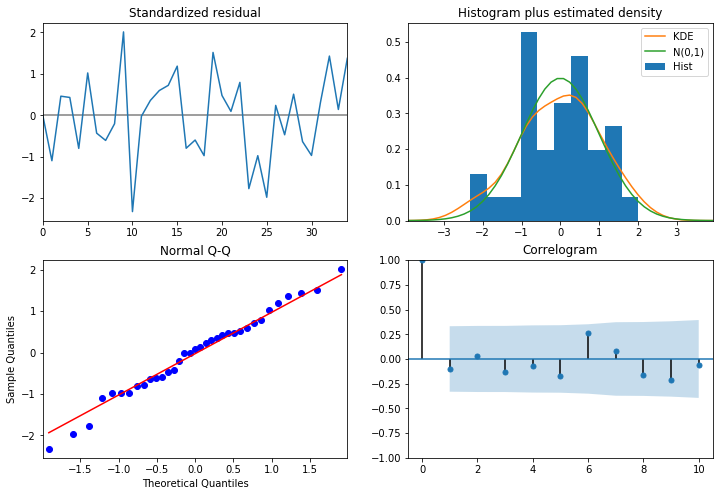

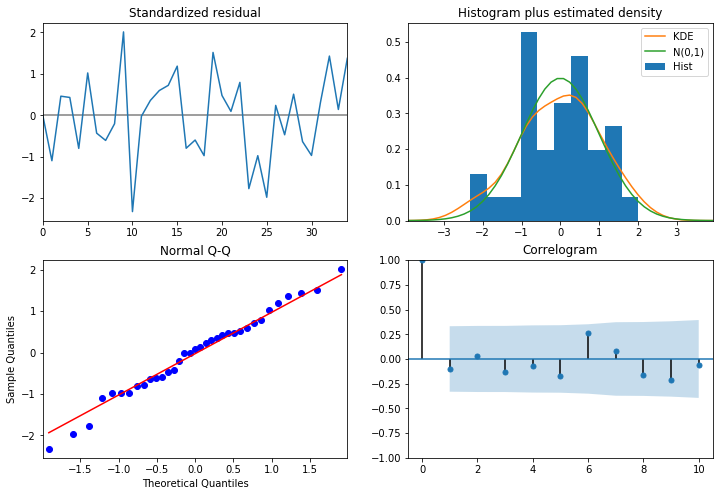

In [51]:
stepwise_model_log.plot_diagnostics(figsize=(12,8))

In [52]:
forecasted = future_forecast_log.Prediction
actual = monthly_data_furniture.loc['2017-01-01':]
mse = ((forecasted - actual) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is inf
The Root Mean Squared Error of our forecasts is inf


In [53]:
future_forecast_log = stepwise_model_log.predict(n_periods=18)

In [49]:
future_forecast_log = pd.DataFrame(future_forecast_log,columns=["Prediction"])
future_forecast_log

Prediction
BillDate                 
2017-01-01  2.887763e+183
2017-02-01  1.248815e+156
2017-03-01  1.105366e+247
2017-04-01  4.992179e+279
2017-05-01  3.975981e+306
2017-06-01  2.406665e+273
2017-07-01  4.047817e+296
2017-08-01  2.157130e+231
2017-09-01            inf
2017-10-01            inf
2017-11-01            inf
2017-12-01            inf

In [55]:
future_forecast_log["Prediction"] = np.exp(future_forecast_log.Prediction)

/Users/c_shashank/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning:

overflow encountered in exp



### RMSE on SCT = 64.59

In [56]:
future_forecast_log 

Prediction
0   2.887763e+183
1   1.248815e+156
2   1.105366e+247
3   4.992179e+279
4   3.975981e+306
5   2.406665e+273
6   4.047817e+296
7   2.157130e+231
8             inf
9             inf
10            inf
11            inf
12  6.114797e+232
13  8.000958e+209
14  3.973268e+292
15            inf
16            inf
17            inf

In [57]:
#required_preds = future_forecast_log.iloc[12:,]
#required_preds = required_preds.to_csv("Pred1.csv")

In [59]:
stepwise_model_2 = auto_arima(monthly_data_furniture, start_p=0, start_q=0, m=12,
                           start_P=0,start_Q = 0,d=1, D=1, seasonal=True, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model_2.aic())

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=450.863, BIC=453.973, Fit time=0.019 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=434.725, BIC=440.946, Fit time=0.304 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=439.339, BIC=444.005, Fit time=0.068 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=436.713, BIC=444.490, Fit time=0.701 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=444.461, BIC=449.128, Fit time=0.224 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=434.754, BIC=442.531, Fit time=0.433 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=426.728, BIC=43

In [60]:
stepwise_model_2.fit(train)

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(1, 1, 0, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)

In [62]:
future_forecast_2 = stepwise_model_2.predict(n_periods=12)

In [64]:
future_forecast_2 = pd.DataFrame(future_forecast_2,index=test.index,columns=["Prediction"])
future_forecast_2

Prediction
BillDate              
2017-01-01    5.895656
2017-02-01    5.510931
2017-03-01    6.364684
2017-04-01    6.261168
2017-05-01    6.475140
2017-06-01    6.131038
2017-07-01    6.349380
2017-08-01    6.024564
2017-09-01    6.924780
2017-10-01    6.507027
2017-11-01    7.040748
2017-12-01    7.113027

In [66]:
future_forecast_2["Prediction"] = np.exp(future_forecast_2.Prediction)
future_forecast_2

Prediction
BillDate               
2017-01-01   363.455010
2017-02-01   247.381443
2017-03-01   580.961500
2017-04-01   523.830355
2017-05-01   648.810070
2017-06-01   459.913207
2017-07-01   572.137993
2017-08-01   413.461267
2017-09-01  1017.170685
2017-10-01   669.831950
2017-11-01  1142.241557
2017-12-01  1227.858999

In [68]:
pd.concat([monthly_data_furniture,future_forecast_2],axis=1).iplot()

### Can be seen from the plot that the actual and predicted values are deviating from each other

## Seasonal ARIMA (SARIMA)

In [50]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [51]:
warnings.filterwarnings("ignore")
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(monthly_data_furniture,order=param,seasonal_order=param_seasonal,enforce_stationarity= False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
                continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:732.1449709528243
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1496.9065335475398
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:434.9522910290901
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:434.8270071743497
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1187.7790082277158
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:301.3945496419233
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:687.1603889422056
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2848.703136717808
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:424.065095465214
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:434.2362352763748
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2456.1462123055258
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:301.5425236725655
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:647.6678896496314
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1337.6722340410395
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:437.0872507120172
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:449.35248162993906
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1338.797870142829
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:283.47755191582365
ARIMA

In [56]:
mod = sm.tsa.statespace.SARIMAX(monthly_data_furniture,
                                order=(0,0,0),
                                seasonal_order=(0, 1, 0, 12),
                                enforce_stationarity= False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                            Statespace Model Results                            
Dep. Variable:                 Quantity   No. Observations:                   48
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -216.476
Date:                  Sat, 30 Mar 2019   AIC                            434.952
Time:                          23:12:40   BIC                            436.508
Sample:                      01-01-2014   HQIC                           435.489
                           - 12-01-2017                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.378e+04   3644.705      3.781      0.000    6638.493    2.09e+04
Ljung-Box (Q):                       27.77   Jarque-Bera (JB):                 0.05
Prob(Q):                       

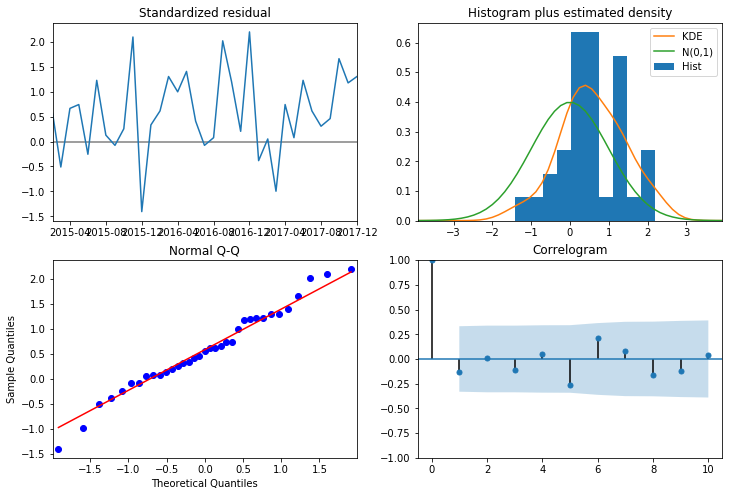

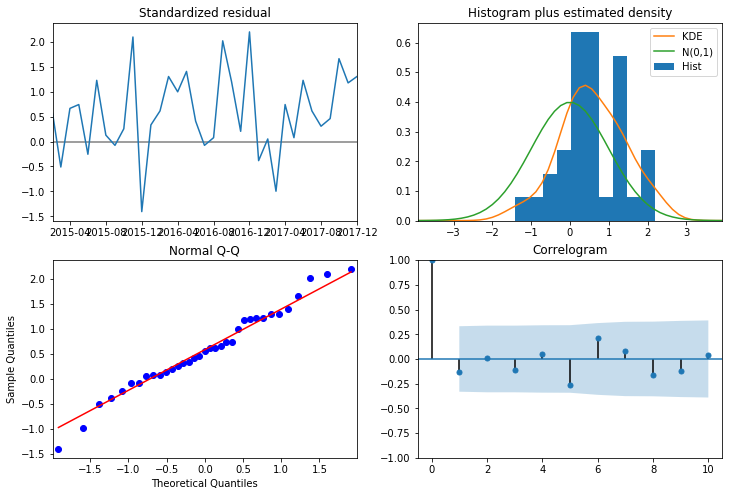

In [57]:
results.plot_diagnostics(figsize=(12,8))

In [58]:
pred = results.forecast(steps=6)

In [59]:
pred

2018-01-01    258.0
2018-02-01    213.0
2018-03-01    369.0
2018-04-01    525.0
2018-05-01    552.0
2018-06-01    528.0
Freq: MS, dtype: float64

### RMSE on SCT = 0.0 

## HoltWinters Exponential Smoothing

In [60]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [76]:
#fit1 = ExponentialSmoothing(monthly_data_furniture, seasonal_periods=12, trend='add', seasonal='add').fit(use_boxcox=True)
#fit2 = ExponentialSmoothing(monthly_data_furniture, seasonal_periods=12, trend='add', seasonal='mul').fit(use_boxcox=True)
fit3 = ExponentialSmoothing(monthly_data_furniture, seasonal_periods=12, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
#fit4 = ExponentialSmoothing(monthly_data_furniture, seasonal_periods=12, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)

In [78]:
fit3.forecast(steps= 6)

2018-01-01    329.659315
2018-02-01    254.917139
2018-03-01    477.714176
2018-04-01    586.540789
2018-05-01    638.420727
2018-06-01    577.083057
Freq: MS, dtype: float64

### RMSE on SCT = 73.45

# Segmenting first 6 months data from each year and forecasting

In [64]:
monthly_data_furniture1 = monthly_data_furniture.iloc[0:6,]

In [65]:
monthly_data_furniture2 = monthly_data_furniture.iloc[12:18]

In [66]:
monthly_data_furniture3 = monthly_data_furniture.iloc[24:30]

In [67]:
monthly_data_furniture4 = monthly_data_furniture.iloc[36:42]

In [68]:
monthly_data_final = pd.concat([monthly_data_furniture1,monthly_data_furniture2,monthly_data_furniture3,
                                monthly_data_furniture4], axis = 0)

In [69]:
monthly_data_final.head()

BillDate
2014-01-01    210
2014-02-01     69
2014-03-01    393
2014-04-01    243
2014-05-01    291
Name: Quantity, dtype: int64

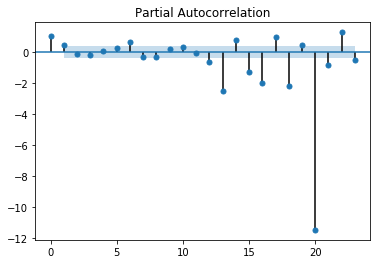

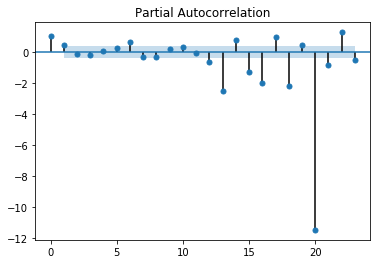

In [70]:
plot_pacf(monthly_data_final)

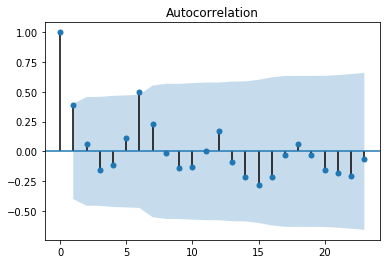

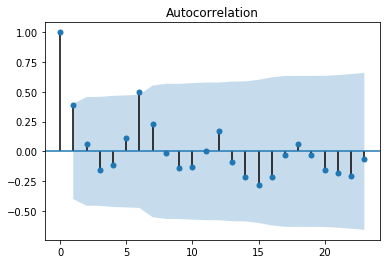

In [71]:
plot_acf(monthly_data_final)

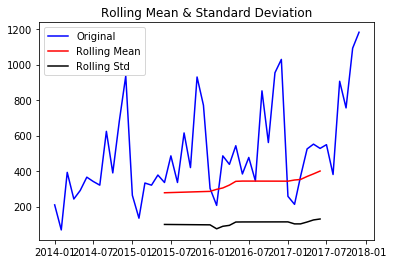

Results of Dickey-Fuller Test:
Test Statistic                 -3.677030
p-value                         0.004448
#Lags Used                      0.000000
Number of Observations Used    47.000000
Critical Value (1%)            -3.577848
Critical Value (5%)            -2.925338
Critical Value (10%)           -2.600774
dtype: float64


In [72]:
test_stationarity(monthly_data_final)

In [73]:
monthly_data_final.iplot(title="Furniture sales for first 6 months from 2014 to 2017")

## Model Building

### Auto-ARIMA

In [74]:
stepwise_model_f = auto_arima(monthly_data_final, start_p=0, start_q=0,m=6,
                           start_P=0, start_Q = 0,seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model_log.aic())

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 6); AIC=208.856, BIC=210.522, Fit time=0.028 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 6); AIC=207.118, BIC=210.451, Fit time=0.167 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 6); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 6); AIC=205.861, BIC=208.360, Fit time=0.058 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 1, 6); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 6); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 1, 0, 6); AIC=207.853, BIC=211.186, Fit time=0.105 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 6); AIC=207.852, BIC=211.185, Fit time=0.160 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 0, 6); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.531 seconds
424.916852683863


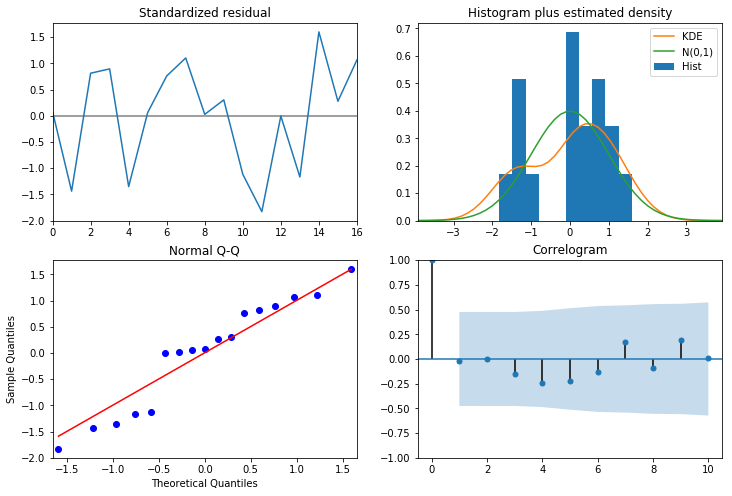

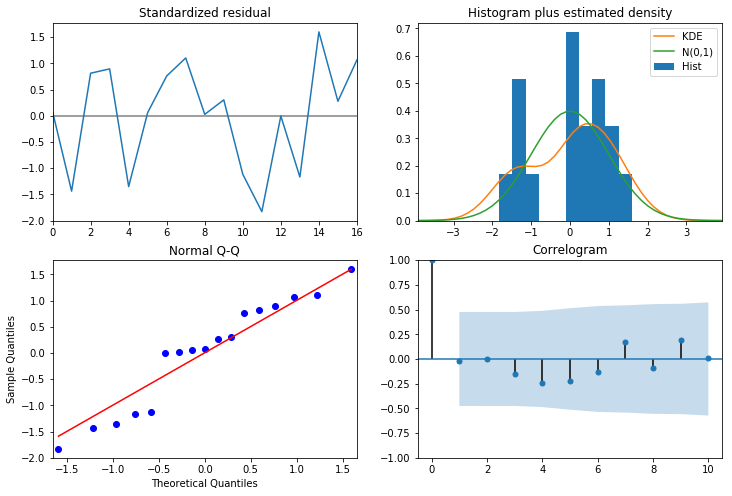

In [75]:
stepwise_model_f.plot_diagnostics(figsize=(12,8))

### Seasonal Arima

In [76]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 6) for x in list(itertools.product(p, d, q))]

In [77]:
warnings.filterwarnings("ignore")
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(monthly_data_final,order=param,seasonal_order=param_seasonal,enforce_stationarity= False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}6 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
                continue

ARIMA(0, 0, 0)x(0, 0, 0, 6)6 - AIC:338.9837341324593
ARIMA(0, 0, 0)x(0, 0, 1, 6)6 - AIC:793.9965520598456
ARIMA(0, 0, 0)x(0, 1, 0, 6)6 - AIC:203.5162511884967
ARIMA(0, 0, 0)x(1, 0, 0, 6)6 - AIC:212.69622259335947
ARIMA(0, 0, 0)x(1, 0, 1, 6)6 - AIC:611.0596009799863
ARIMA(0, 0, 0)x(1, 1, 0, 6)6 - AIC:147.9404570602751
ARIMA(0, 0, 1)x(0, 0, 0, 6)6 - AIC:309.6571584854644
ARIMA(0, 0, 1)x(0, 0, 1, 6)6 - AIC:1327.1039927725064
ARIMA(0, 0, 1)x(0, 1, 0, 6)6 - AIC:193.08483729521976
ARIMA(0, 0, 1)x(1, 0, 0, 6)6 - AIC:214.8132923695472
ARIMA(0, 0, 1)x(1, 0, 1, 6)6 - AIC:1209.680637185912
ARIMA(0, 0, 1)x(1, 1, 0, 6)6 - AIC:149.14487630575738
ARIMA(0, 1, 0)x(0, 0, 0, 6)6 - AIC:280.29254280847954
ARIMA(0, 1, 0)x(0, 0, 1, 6)6 - AIC:644.7738623752757
ARIMA(0, 1, 0)x(0, 1, 0, 6)6 - AIC:195.80665778925032
ARIMA(0, 1, 0)x(1, 0, 0, 6)6 - AIC:202.86854914476027
ARIMA(0, 1, 0)x(1, 0, 1, 6)6 - AIC:649.778176629941
ARIMA(0, 1, 0)x(1, 1, 0, 6)6 - AIC:134.86286939025683
ARIMA(0, 1, 1)x(0, 0, 0, 6)6 - AIC:262.

In [78]:
mod = sm.tsa.statespace.SARIMAX(monthly_data_final,
                                order=(0,0,0),
                                seasonal_order=(1, 1 , 0, 6),
                                enforce_stationarity= False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                            Statespace Model Results                           
Dep. Variable:                Quantity   No. Observations:                   24
Model:             SARIMAX(1, 1, 0, 6)   Log Likelihood                 -71.970
Date:                 Sat, 30 Mar 2019   AIC                            147.940
Time:                         23:26:10   BIC                            148.910
Sample:                              0   HQIC                           147.581
                                  - 24                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L6        0.1931      0.313      0.617      0.537      -0.420       0.807
sigma2      9482.0994   5611.685      1.690      0.091   -1516.602    2.05e+04
Ljung-Box (Q):                       12.88  

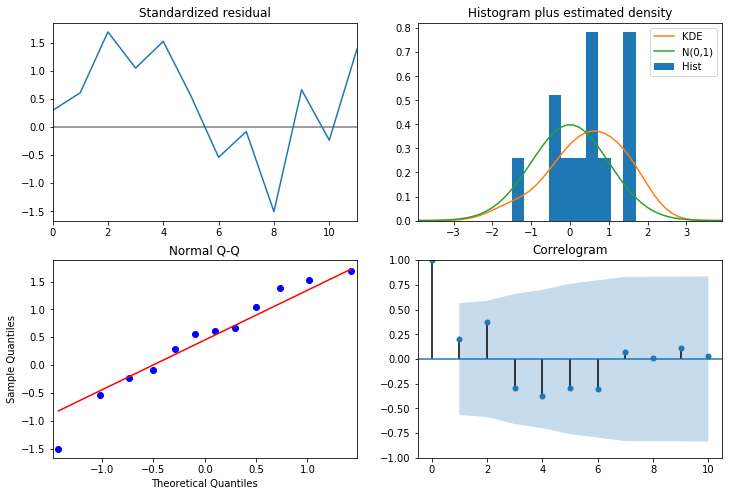

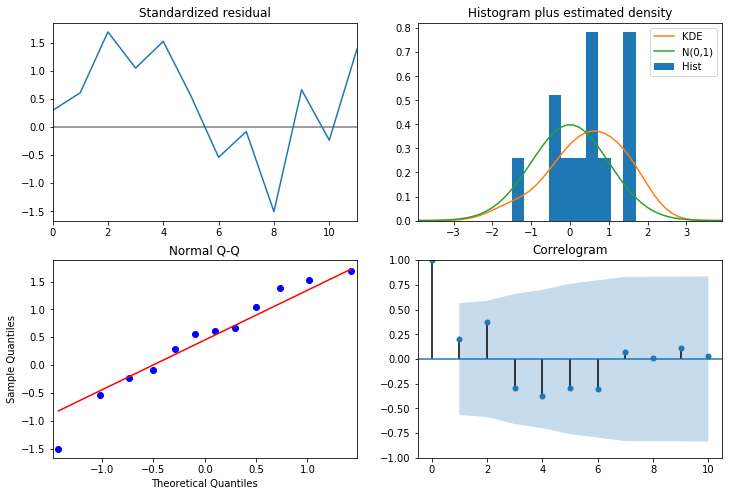

In [79]:
results.plot_diagnostics(figsize= (12,8))

In [80]:
pred = results.forecast(steps=6)

In [81]:
pred

24    249.310034
25    214.158662
26    346.406088
27    541.800601
28    553.737993
29    555.807892
dtype: float64

#### RMSE on SCT = 15.26

In [82]:
mod = sm.tsa.statespace.SARIMAX(monthly_data_final,
                                order=(0,0,0),
                                seasonal_order=(0, 1 , 0, 6),
                                enforce_stationarity= False,
                                enforce_invertibility=False)
                              
results = mod.fit()
print(results.summary())

                            Statespace Model Results                           
Dep. Variable:                Quantity   No. Observations:                   24
Model:             SARIMAX(0, 1, 0, 6)   Log Likelihood                -100.758
Date:                 Sat, 30 Mar 2019   AIC                            203.516
Time:                         23:27:10   BIC                            204.349
Sample:                              0   HQIC                           203.599
                                  - 24                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8233.2046   3973.116      2.072      0.038     446.041     1.6e+04
Ljung-Box (Q):                       14.82   Jarque-Bera (JB):                 0.72
Prob(Q):                              0

In [83]:
pred = results.forecast(steps=6)

In [84]:
pred

24    258.0
25    213.0
26    369.0
27    525.0
28    552.0
29    528.0
dtype: float64

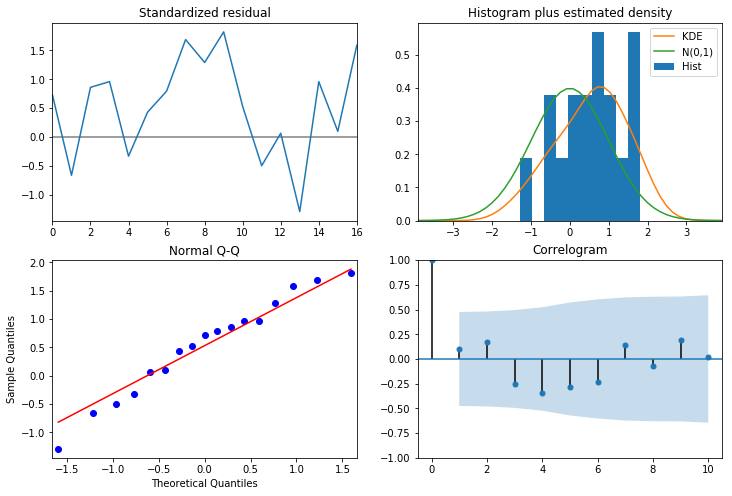

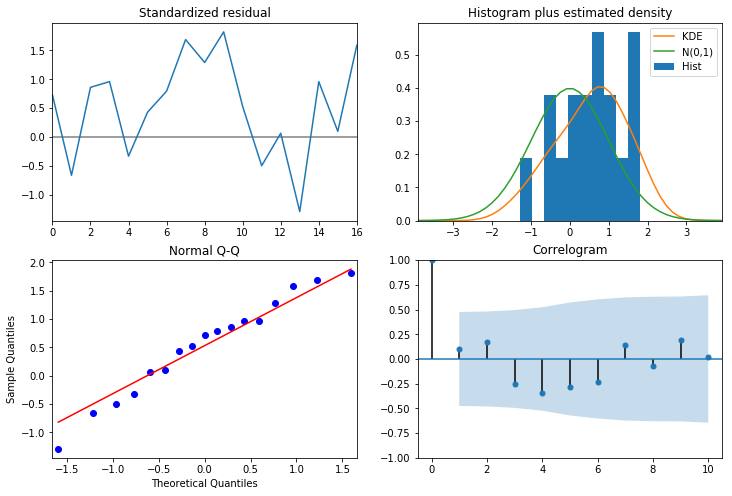

In [85]:
results.plot_diagnostics(figsize=(12,8))

#### RMSE on SCT = 0.0

# BoxCox Transformation on Data

In [86]:
from scipy.special import boxcox, inv_boxcox
from scipy import stats

In [87]:
boxcox_data, lmbd = stats.boxcox(monthly_data_furniture)

In [88]:
boxcox_data

array([12.6981472 ,  8.26938026, 15.89082756, 13.39117849, 14.28822677,
       15.49861714, 15.13227824, 14.79638485, 18.64349179, 15.84821558,
       19.23497918, 21.37767861, 13.7978903 , 10.76896722, 14.99017619,
       14.79638485, 15.67539391, 15.03784435, 17.11007922, 15.03784435,
       18.55131374, 16.26427923, 21.33177965, 20.0301896 , 14.49577609,
       12.63138638, 17.11007922, 16.50383793, 17.77688958, 15.76228583,
       16.99976753, 15.179053  , 20.71494395, 17.97705055, 21.51412941,
       22.06369268, 13.68411306, 12.76423182, 15.54319407, 17.57194287,
       17.87755149, 17.60644475, 17.84412833, 15.71896176, 21.14604499,
       19.89781682, 22.50366736, 23.1018503 ])

In [89]:
warnings.filterwarnings("ignore")
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(boxcox_data,order=param,seasonal_order=param_seasonal,enforce_stationarity= False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
                continue

ARIMA(0, 0, 0)x(0, 0, 0, 6)12 - AIC:402.1854434948426
ARIMA(0, 0, 0)x(0, 0, 1, 6)12 - AIC:327.9499902041496
ARIMA(0, 0, 0)x(0, 1, 0, 6)12 - AIC:229.71468761467693
ARIMA(0, 0, 0)x(0, 1, 1, 6)12 - AIC:171.13930813998036
ARIMA(0, 0, 0)x(1, 0, 0, 6)12 - AIC:235.89523777440058
ARIMA(0, 0, 0)x(1, 0, 1, 6)12 - AIC:196.32702347674052
ARIMA(0, 0, 0)x(1, 1, 0, 6)12 - AIC:126.27300312212805
ARIMA(0, 0, 0)x(1, 1, 1, 6)12 - AIC:119.03319325550893
ARIMA(0, 0, 1)x(0, 0, 0, 6)12 - AIC:348.9309976703393
ARIMA(0, 0, 1)x(0, 0, 1, 6)12 - AIC:285.57877571600613
ARIMA(0, 0, 1)x(0, 1, 0, 6)12 - AIC:213.9600886180624
ARIMA(0, 0, 1)x(0, 1, 1, 6)12 - AIC:158.77466575348552
ARIMA(0, 0, 1)x(1, 0, 0, 6)12 - AIC:227.71884820512116
ARIMA(0, 0, 1)x(1, 0, 1, 6)12 - AIC:192.60686262404732
ARIMA(0, 0, 1)x(1, 1, 0, 6)12 - AIC:126.55390497641788
ARIMA(0, 0, 1)x(1, 1, 1, 6)12 - AIC:114.8198717260384
ARIMA(0, 1, 0)x(0, 0, 0, 6)12 - AIC:241.0415584772707
ARIMA(0, 1, 0)x(0, 0, 1, 6)12 - AIC:210.58671932141993
ARIMA(0, 1, 0)x(

In [90]:
mod = sm.tsa.statespace.SARIMAX(boxcox_data,
                                order=(0,0,0),
                                seasonal_order=(1, 1 ,0, 12),
                                enforce_stationarity= False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                            Statespace Model Results                            
Dep. Variable:                        y   No. Observations:                   48
Model:             SARIMAX(1, 1, 0, 12)   Log Likelihood                 -40.056
Date:                  Sat, 30 Mar 2019   AIC                             84.112
Time:                          23:27:21   BIC                             86.468
Sample:                               0   HQIC                            84.737
                                   - 48                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.2495      0.212      1.180      0.238      -0.165       0.664
sigma2         1.6489      0.659      2.500      0.012       0.356       2.941
Ljung-Box (Q):                      

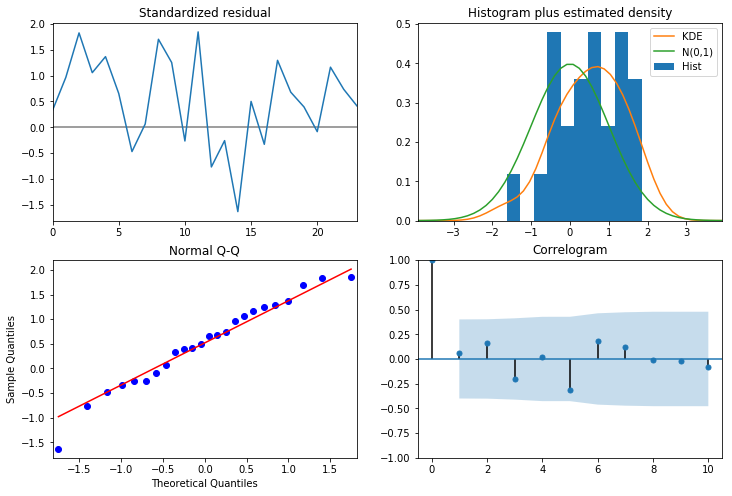

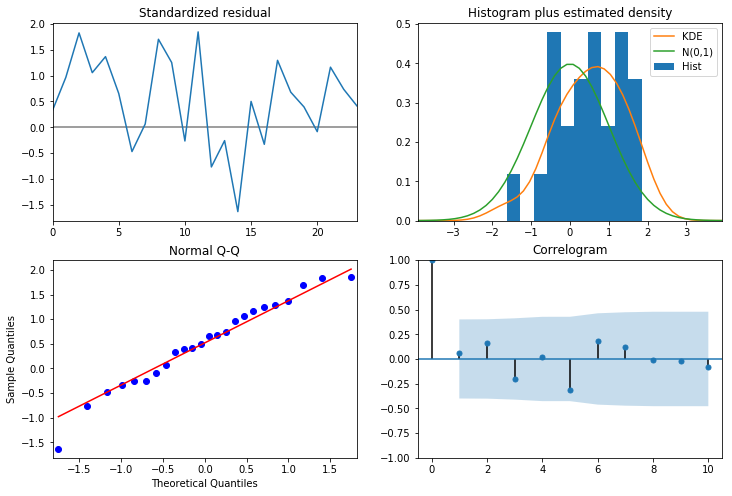

In [91]:
results.plot_diagnostics(figsize=(12,8))

In [92]:
pred = results.forecast(steps=6)

In [93]:
pred = inv_boxcox(pred, lmbd)

In [94]:
pred = pd.Series(pred)

In [95]:
pred

0    247.560127
1    214.516390
2    343.274281
3    548.494680
4    554.262393
5    569.193582
dtype: float64